In [24]:
import os
# Set environment variable to suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from src.neural_networks.get_data import get_tf_data, stack_1d_features, normalize_1d_features_with_mean_std, load_cv_data, make_importance_sampling_dataset
from src.neural_networks.nn_forecast import NNForecast
from src.visualization.twcrpss_plot import make_twcrpss_plot_tf
from src.visualization.brier_score import make_brier_skill_plot_tf
from src.visualization.pit import make_cpit_diagram_tf, comp_multiple_pit_scores
from src.visualization.reliability_diagram import make_reliability_and_sharpness_tf
from src.training.training import load_model
from src.visualization.plot_forecasts import plot_forecast_pdf_tf
from src.climatology.climatology import Climatology
from src.visualization.brier_score import get_brier_scores_tf
from src.models.emos import BootstrapEmos, EMOS

import sklearn

from scipy.stats import norm, pareto

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import optuna

In [25]:
all_features = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']

location_features = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']

scale_features = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']

features_names_dict = {name: 1 for name in all_features}

features_names_dict['wind_speed'] = 15

ignore = ['229', '285', '323']

In [26]:
train_data, test_data, data_info = load_cv_data(3, features_names_dict)

def remove_other_info(X, y):
    return {'features_emos': X['features_emos']}, y

def remove_label(X, y):
    return X['features_emos'], y

train_data = train_data.map(remove_other_info)

train_data_is = train_data.map(remove_label)

train_data_is = make_importance_sampling_dataset(train_data_is)

data_list = list(train_data_is.as_numpy_iterator())


In [27]:
features = np.array([x[0] for x in data_list])
targets = np.array([x[1] for x in data_list])
sample_weights = np.array([x[2] for x in data_list])

dataset_dict = {
    'features_emos': features,
    'y': targets,
    'w': sample_weights
}

train_data_is = tf.data.Dataset.from_tensor_slices(dataset_dict)

def correct_map(sample_dict):
    return {'features_emos': sample_dict['features_emos']}, sample_dict['y'], sample_dict['w']

train_data_is = train_data_is.map(correct_map)

In [28]:
dataset_length_is = train_data_is.cardinality()

print(dataset_length_is)

train_data_is = train_data_is.shuffle(dataset_length_is)

train_data_is = train_data_is.batch(32)

train_data_is = train_data_is.prefetch(tf.data.experimental.AUTOTUNE)

tf.Tensor(25165, shape=(), dtype=int64)


In [29]:
def const_weight_func(X, y):
    """
    Attaches a uniform weight to each sample in the dataset.
    """
    return X, y, tf.constant(1, dtype=tf.float32)

train_data = train_data.map(const_weight_func)

In [30]:
dataset_length = train_data.cardinality()

train_data = train_data.shuffle(dataset_length)

print(dataset_length)

train_data = train_data.batch(32)

train_data = train_data.prefetch(tf.data.experimental.AUTOTUNE)

tf.Tensor(15733, shape=(), dtype=int64)


In [31]:
test_data = test_data.batch(test_data.cardinality())

In [32]:
loss = "loss_CRPS_sample"
#loss = "loss_cPIT"
samples = 300

# possible chain functions: 'chain_function_indicator' and 'chain_function_normal_cdf'
# if chain_function_indicator is chosen, threshold is not necessary
# if chain_function_normal_cdf is chosen, threshold is necessary
chain_function = "chain_function_normal_cdf_plus_constant"
threshold = 100
chain_function_mean = 9
chain_function_std = 0.5
chain_function_constant = 0.001


# possible optimizers: 'SGD', 'Adam'
optimizer = "Adam"
learning_rate = 0.01

# possible forecast distributions: 'distr_trunc_normal', 'distr_log_normal', 'distr_gev' and 'distr_mixture'/'distr_mixture_linear', which can be a mixture distribution of two previously mentioned distributions.
forecast_distribution = "distr_trunc_normal"

# necessary in case of a mixture distribution
distribution_1 = "distr_trunc_normal"
distribution_2 = "distr_log_normal"

random_init = False
printing = True
subset_size = None

setup = {'loss': loss,
         'samples': samples, 
         'optimizer': optimizer, 
         'learning_rate': learning_rate, 
         'forecast_distribution': forecast_distribution,
         'chain_function': chain_function,
         'threshold': threshold,
         'distribution_1': distribution_1,
         'distribution_2': distribution_2,
         'chain_function_mean': chain_function_mean,
         'chain_function_std': chain_function_std,
         'chain_function_constant': chain_function_constant,
         'all_features': all_features,
         'location_features': location_features,
         'scale_features': scale_features,
         'random_init': random_init,
         'subset_size': subset_size,
        'printing': printing,
         }

In [15]:
emos_is = EMOS(setup)

emos_base = EMOS(setup)

In [16]:
epochs = 3

losses_is = emos_is.fit(train_data_is, epochs, True, test_data)['validation_loss']

12
13
12
12
13
13
12
13
13
12
10
12
12
13
13
12
13
12
13
12
13
13
13
12
13
13
13
12
13
13
13
13
12
13
13
13
13
13
13
12
13
13
13
13
12
13
13
13
12
13
13
13
13
12
13
13
12
Epoch:  0  Loss:  0.851003349
11
13
12
13
13
13
13
12
13
11
11
12
13
12
13
13
12
12
12
12
13
13
12
13
13
13
12
13
13
13
12
13
13
12
13
13
12
13
13
12
13
13
13
12
13
13
13
12
13
13
13
12
13
13
13
12
13
13
Epoch:  1  Loss:  0.566374123
11
12
13
12
13
13
13
13
12
13
13
12
13
13
13
12
13
13
13
12
13
13
13
12
13
13
13
12
13
13
12
13
12
13
13
12
13
13
12
13
13
12
13
13
13
13
13
12
13
12
13
13
13
12
13
13
13
12
Epoch:  2  Loss:  0.567204237
11
13
13
12
13
13
13
13
12
13
13
12
13
13
13
13
12
13
13
13
12
13
13
13
13
12
13
13
13
12
13
13
13
13
12
13
13
13
12
13
13
13
12
13
13
13
12
13
13
13
13
12
13
13
12
13
13
Epoch:  3  Loss:  0.566901684
11
12
13
13
13
12
13
13
13
12
13
13
13
13
12
13
13
13
12
13
13
13
13
12
13
13
13
13
12
13
13
13
12
13
13
12
13
13
13
12
13
13
12
13
12
13
13
13
12
13
13
13
12
13
13
13
12
Epoch:  4  Loss:  0

In [17]:
print(emos_is.CRPS(test_data, 500))

0.88839805


In [18]:
epochs = 3

losses = emos_base.fit(train_data, epochs, True, test_data)['validation_loss']

9
13
12
13
13
12
13
12
13
13
12
13
13
12
13
13
13
12
13
13
12
13
13
13
13
12
13
13
13
13
12
13
13
13
12
13
Epoch:  0  Loss:  1.6342355
8
13
12
13
13
13
12
13
13
12
13
13
13
12
13
13
13
13
12
13
13
13
12
13
13
12
13
13
13
12
13
13
13
12
13
13
Epoch:  1  Loss:  0.912398875
8
13
12
13
13
13
12
13
13
13
12
13
13
12
13
13
13
13
12
13
13
13
12
13
13
13
13
12
13
13
13
13
12
13
13
12
Epoch:  2  Loss:  0.906804562
8
13
13
12
13
13
13
12
13
13
13
12
13
13
12
13
13
13
12
13
13
12
13
13
13
13
12
13
13
13
12
14
12
13
13
13
Epoch:  3  Loss:  0.907904744
8
12
13
13
12
13
13
13
13
12
13
13
13
12
13
13
12
13
13
13
13
12
13
13
12
13
13
12
13
13
13
12
13
13
13
12
Epoch:  4  Loss:  0.906202674


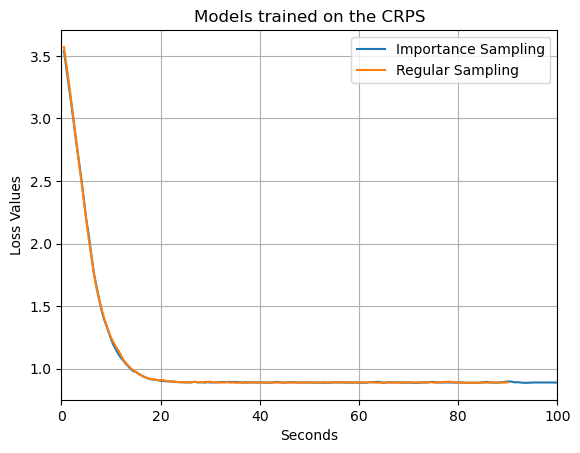

In [20]:
plt.plot(list(losses_is.keys()), list(losses_is.values()), label='Importance Sampling')
plt.plot(list(losses.keys()), list(losses.values()), label='Regular Sampling')
plt.xlabel('Seconds')
plt.ylabel("Loss Values")
plt.xlim(0, 100)
plt.grid()
plt.legend()
plt.title("Models trained on the CRPS")
plt.show()

In [33]:
setup['loss'] = 'loss_twCRPS_sample'

In [34]:
emos_weight_is = EMOS(setup)

emos_weight_base = EMOS(setup)

In [35]:
epochs = 4

losses_is_w = emos_weight_is.fit(train_data_is, epochs, True, test_data)['validation_loss']

8
7
6
7
7
7
7
7
6
7
7
7
6
7
7
7
7
7
7
7
7
7
6
7
7
7
7
7
7
7
7
7
7
7
6
7
7
7
7
6
7
7
7
7
7
7
7
6
7
7
7
7
7
6
7
7
7
7
7
7
6
7
7
7
7
7
7
7
6
7
7
7
7
7
7
7
6
7
7
7
7
7
7
7
7
7
6
7
7
7
7
7
7
7
6
7
7
7
7
Epoch:  0  Loss:  0.128250882
7
5
7
7
7
7
7
7
6
7
7
7
7
7
7
7
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
6
7
7
7
7
7
7
7
7
6
7
7
7
7
7
7
7
6
7
7
7
7
7
7
7
7
7
7
7
7
6
7
7
7
7
7
7
7
7
6
7
7
7
7
7
7
7
7
7
7
7
Epoch:  1  Loss:  0.104973108
5
7
7
7
7
7
7
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
6
7
7
7
7
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
6
7
7
7
7
7
7
7
7
7
7
7
7
6
7
7
Epoch:  2  Loss:  0.104182027
6
7
7
7
7
7
6
7
7
7
7
7
7
7
7
7
7
7
7
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
6
7
7
7
Epoch:  3  Loss:  0.104004107


In [36]:
epochs = 4

losses_w = emos_weight_base.fit(train_data, epochs, True, test_data)['validation_loss']

6
7
6
7
7
7
7
7
7
7
6
7
7
7
7
7
7
7
6
7
7
7
6
7
7
7
7
7
7
6
7
7
7
7
7
7
7
7
7
7
7
6
7
7
7
7
6
7
7
7
7
7
7
7
6
7
7
7
7
7
7
7
Epoch:  0  Loss:  0.235009342
5
5
7
7
7
7
7
7
7
7
7
6
7
7
7
6
7
7
7
7
7
7
6
7
7
7
7
7
7
7
6
7
7
7
7
7
7
7
7
6
7
7
7
7
7
7
6
7
7
7
7
7
7
7
6
7
7
7
7
7
6
7
7
Epoch:  1  Loss:  0.170943931
5
6
7
7
7
6
7
7
7
7
7
7
7
7
6
7
7
7
7
6
7
7
7
7
7
7
7
7
7
7
7
6
7
7
7
7
7
7
7
6
7
7
7
7
7
7
6
7
7
7
7
7
7
7
6
7
7
7
7
7
7
7
7
Epoch:  2  Loss:  0.168193862
4
6
7
7
7
7
7
7
7
6
7
7
7
7
7
7
7
7
7
6
7
7
7
7
7
7
7
6
7
7
7
7
7
7
7
7
7
7
7
7
6
7
7
7
7
7
7
7
7
7
7
7
6
7
7
7
7
7
7
6
7
7
7
Epoch:  3  Loss:  0.166949853


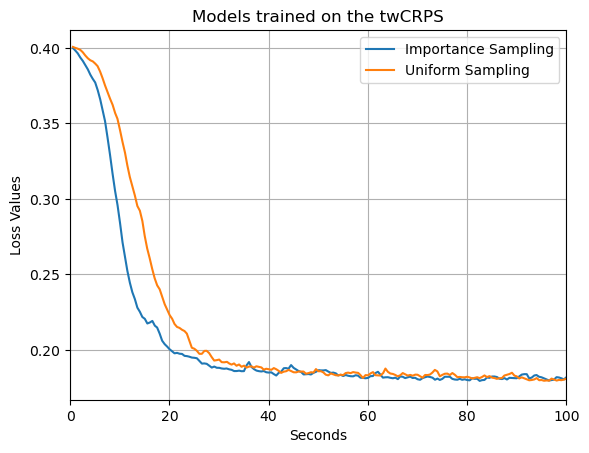

In [39]:
plt.plot(list(losses_is_w.keys()), list(losses_is_w.values()), label='Importance Sampling')
plt.plot(list(losses_w.keys()), list(losses_w.values()), label='Uniform Sampling')
plt.xlabel('Seconds')
plt.ylabel("Loss Values")
plt.grid()
plt.xlim(0, 100)
plt.legend()
plt.title("Models trained on the twCRPS")
plt.show()